In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from typing import List, Dict, Tuple

%matplotlib inline

In [2]:
drivers = pd.read_csv("dataset/drivers.csv")
drivers_standings = pd.read_csv("dataset/driver_standings.csv")
races = pd.read_csv("dataset/races.csv")
results = pd.read_csv("dataset/results.csv")

In [3]:
# drivers' details, driverId, dob, ... and all the races he participated in
# with the years of those races so foreach driver we have a list of his
# races and the year of each race
driver_positions_per_year = pd.merge(
    drivers[["driverId", "dob", "forename", "surname", "nationality"]],
    results[["raceId", "driverId", "position"]],
    on=["driverId"],
    how="inner",
).merge(races[["raceId", "year"]], on=["raceId"], how="inner")
driver_positions_per_year = driver_positions_per_year[
    driver_positions_per_year["year"] >= 2000
]
# extract the year only from the date of birth
driver_positions_per_year["dob"] = pd.DatetimeIndex(
    driver_positions_per_year["dob"]
).year

# merge their names, makes it easiear to google a driver
driver_positions_per_year["Name"] = (
    driver_positions_per_year["forename"] + " " + driver_positions_per_year["surname"]
)

driver_positions_per_year = driver_positions_per_year.drop("forename", axis=1)
driver_positions_per_year = driver_positions_per_year.drop("surname", axis=1)
driver_positions_per_year = driver_positions_per_year.sort_values(
    by=["driverId", "year", "raceId"]
)
driver_positions_per_year["age"] = (
    driver_positions_per_year["year"] - driver_positions_per_year["dob"]
)

driver_positions_per_year

,driverId,dob,nationality,raceId,position,year,Name,age
368,1,1985,British,36,3,2007,Lewis Hamilton,22
390,1,1985,British,37,2,2007,Lewis Hamilton,22
412,1,1985,British,38,2,2007,Lewis Hamilton,22
434,1,1985,British,39,2,2007,Lewis Hamilton,22
456,1,1985,British,40,2,2007,Lewis Hamilton,22
...,...,...,...,...,...,...,...,...
6518,855,1999,Chinese,1093,12,2022,Guanyu Zhou,23
6538,855,1999,Chinese,1094,13,2022,Guanyu Zhou,23
6558,855,1999,Chinese,1095,12,2022,Guanyu Zhou,23
6578,855,1999,Chinese,1096,12,2022,Guanyu Zhou,23


In [4]:
driver_positions_per_year = driver_positions_per_year[
    driver_positions_per_year["position"] != "\\N"
]
driver_positions_per_year["position"] = driver_positions_per_year["position"].astype(int)

driver_positions_per_year=driver_positions_per_year[driver_positions_per_year["position"]<=20]
driver_positions_per_year["position"].unique()


/tmp/ipykernel_51757/363176470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_positions_per_year["position"] = driver_positions_per_year["position"].astype(int)


array([ 3,  2,  1,  9,  5,  4,  7, 13, 10, 12,  6, 16, 18, 14,  8, 19, 15,
       11, 17, 20])

In [5]:
mean_positions = driver_positions_per_year.groupby(["age"])["position"].mean().reset_index()
mean_positions

,age,position
0,18,9.800000
1,19,8.432432
2,20,10.901786
3,21,10.080000
4,22,10.522145
5,23,10.666667
6,24,9.401980
7,25,8.779026
8,26,9.624615
9,27,8.773196


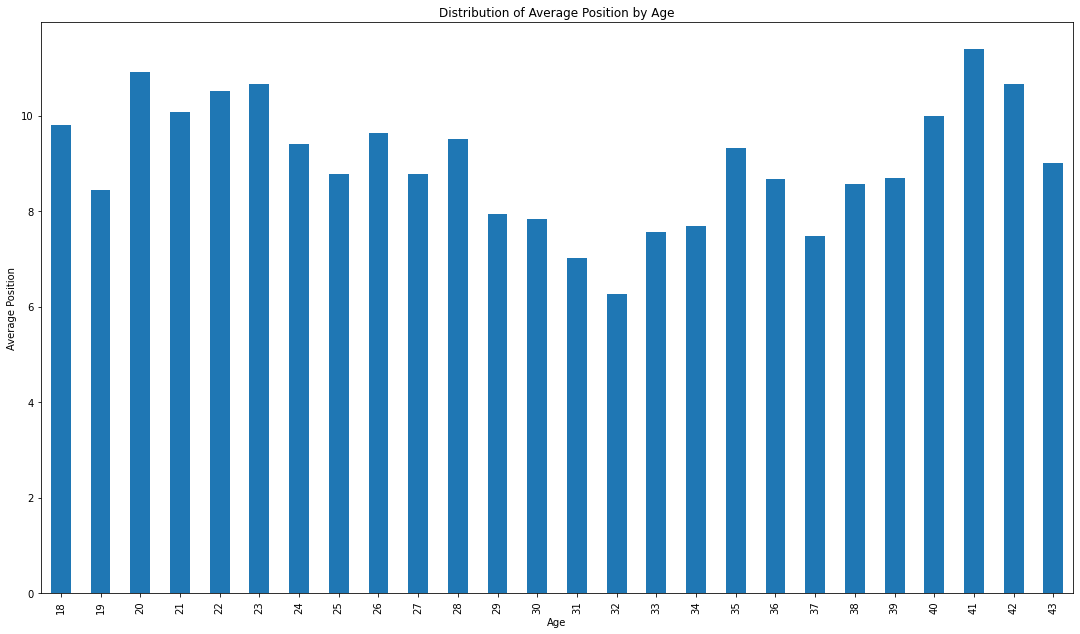

In [8]:

ax = mean_positions.plot(kind='bar', x='age', y='position', legend=False)
# make it bigger
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('Age')
ax.set_ylabel('Average Position')
ax.set_title('Distribution of Average Position by Age')
plt.show()

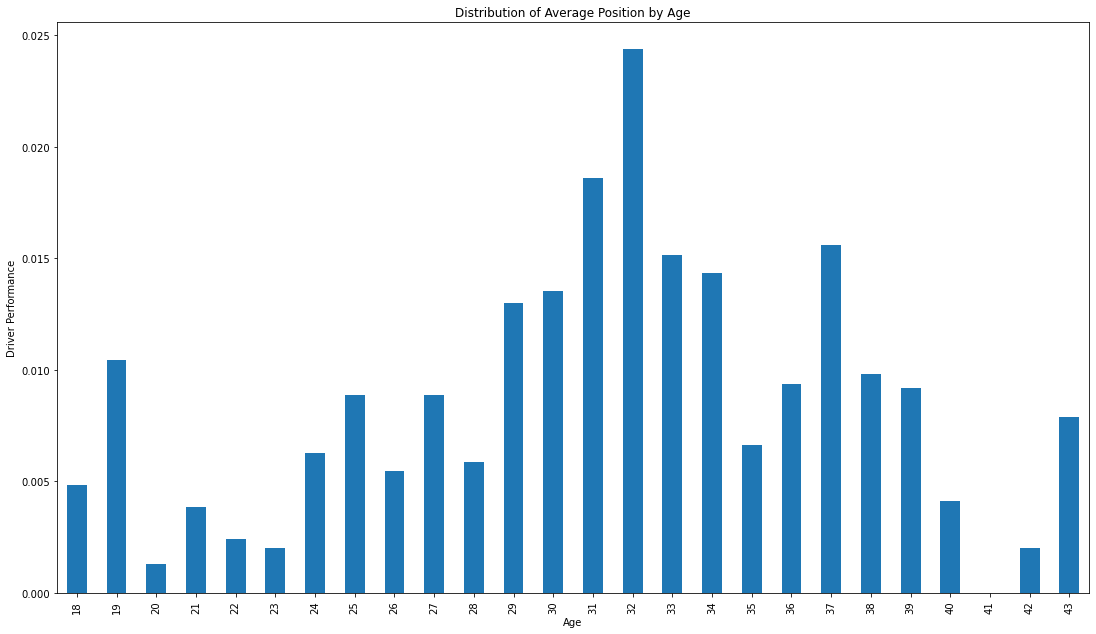

In [11]:
inv_mean_positions = mean_positions.copy()
inv_mean_positions["position"] = 1 / mean_positions["position"]
inv_mean_positions["position"] = (
    inv_mean_positions["position"] - inv_mean_positions["position"].min()
) / inv_mean_positions["position"].sum()
ax = inv_mean_positions.plot(kind="bar", x="age", y="position", legend=False)
# make it bigger
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel("Age")
ax.set_ylabel("Driver Performance")
ax.set_title("Distribution of Average Position by Age")
plt.show()

In [19]:
# df = mean_positions
df = pd.DataFrame({
    'position': [3, 5, 7, 9, 11],
    'age': [25, 28, 30, 32, 35]
})
# add a constant term to the dataframe
df = sm.add_constant(df)

# fit a linear regression model
model = sm.OLS(df['position'], df[['const', 'age']])
results = model.fit()

# print the results
print(results.summary())

# determine the conclusion
alpha = 0.1
if results.pvalues[1] <= alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

                            OLS Regression Results                            
Dep. Variable:               position   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     432.0
Date:                Sun, 14 May 2023   Prob (F-statistic):           0.000244
Time:                        04:20:23   Log-Likelihood:                0.14854
No. Observations:                   5   AIC:                             3.703
Df Residuals:                       3   BIC:                             2.922
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.8276      1.202    -14.829      0.0

/home/karim/FECU/fecu/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


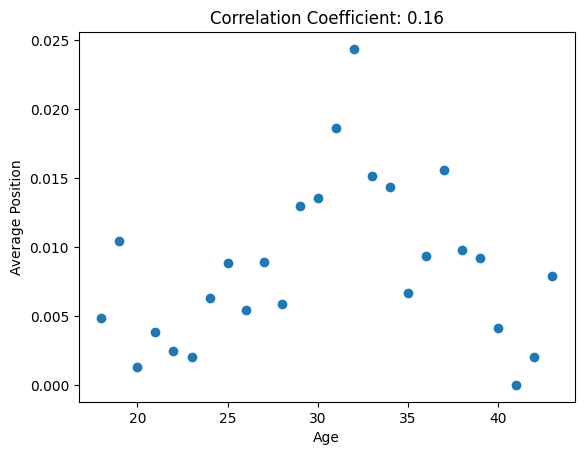

In [20]:
df = inv_mean_positions

# calculate the correlation coefficient
corr_coef = df['position'].corr(df['age'])

# create a scatter plot
plt.scatter(df['age'], df['position'])
plt.xlabel('Age')
plt.ylabel('Average Position')
plt.title(f'Correlation Coefficient: {corr_coef:.2f}')
plt.show()

In [21]:
df = mean_positions

# calculate the z-score for each data point
z_scores = stats.zscore(df)

outliers_zscore = df[(z_scores > 2).any(axis=1) | (z_scores < -2).any(axis=1)]

# print the outliers
print("Outliers (z-score):")
print(outliers_zscore)

df = inv_mean_positions

# calculate the z-score for each data point
z_scores = stats.zscore(df)

outliers_zscore = df[(z_scores > 2).any(axis=1) | (z_scores < -2).any(axis=1)]

# print the outliers
print("Outliers (z-score):")
print(outliers_zscore)


Outliers (z-score):
    age  position
14   32  6.268987
Outliers (z-score):
    age  position
14   32  0.024352
